### This Notebook was built to be run with a Python 3 Kernel

In [1]:
!pip install pandas numpy scikit-learn
!wget https://raw.githubusercontent.com/h2oai/h2o-2/master/smalldata/bank-additional-full.csv

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [76]:
%matplotlib inline
%run -i utils.py

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import ShuffleSplit

#### NOTE: Some methods used below like crossval_estimators(), crossval_estimator(), plot_cv_estimators() and plot_learning_curve() are defined in the file utils.py which is loaded in the beginning.

## Load Data to Pandas

In [77]:
d = pd.read_csv("bank-additional-full.csv", sep=";")
print(d.shape)
d.head(10)

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [78]:
d.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [79]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

## Clean Dataset

There are some columns with N/A values represented in different ways, like 'unknown' in 'default', and 'nonexistent' in 'poutcome'. I will take a look of each one and decide some strategies for the cases.

Additionally, there are some boolean features, these will be replaced by 0 to 'no' and 1 to 'yes'.

I will check the features with possible N/A values.

In [80]:
d.marital.value_counts()

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [81]:
d.education.value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [82]:
d.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [83]:
d.housing.value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [84]:
d.loan.value_counts()

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [85]:
d.drop('duration', axis=1, inplace=True)

In this dataset, we have a very importante feature "duration", it should not be included because if "duration" = 0 then y = 'no'. I will use it after I have reached a good accuracy without it.


In [86]:
d.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

Value '999' in 'pdays' means the user was not contacted, this high value will afect the model, therefore I will add another column to represent if the user was or not contacted and will change the value 999, to the max value different from it. These two changes will be applied because it is difficult for the model to understand the semantic of the feature 'pdays', which means "if the user was contacted", and it is easier to say that more days since the user was contacted will mean "no response".

In [87]:
max_pdays = d.drop(d[d.pdays == 999].index).pdays.max()
d.pdays.replace({999: max_pdays}, inplace = True)

In [88]:
d.poutcome.value_counts()

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [89]:
d.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

I will transform the predicted column 'y'

In [90]:
d.y.replace({'no':0,'yes':1}, inplace=True)

## Split X and y

In [91]:
y = d["y"].as_matrix()
d.drop('y', axis=1, inplace=True)

### One Hot Encoding

After I have checked the features with possible problems, so I will perform a "one hot encoding" over the categorical features. None of them have any special order in which I can associate possible values.

I mean, I can't say 'F':0, 'M':1 because the classifier will interpret male as more or less important as female.

In [92]:
d = pd.get_dummies(d)
X = d
X.head(5)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1,27,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
1,57,1,27,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
2,37,1,27,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0
3,40,1,27,0,1.1,93.994,-36.4,4.857,5191.0,1,...,0,0,0,1,0,0,0,0,1,0
4,56,1,27,0,1.1,93.994,-36.4,4.857,5191.0,0,...,0,0,0,1,0,0,0,0,1,0


In [93]:
X = X.as_matrix()

# Estimators

## Logistic Regression

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

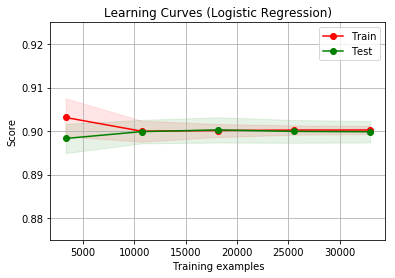

In [94]:
from sklearn.linear_model import LogisticRegression
# Cross validation with 10 iterations, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
LR = LogisticRegression()
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(LR, title, X, y, ylim=(0.875, 0.925), cv=cv, n_jobs=-1)

We can appreciate the learning curve for the Logistic Regression estimator, which is better as it is increases the data. It means this estimator behaves pretty well for this dataset.

## Decision Tree Classifier

There are estimators in which you can change some parameters to change their behavior. One example is the DecisionTreeClassifier in which you can select a **max_depth**, I will play with some different values for it and plot how the estimator behaves.

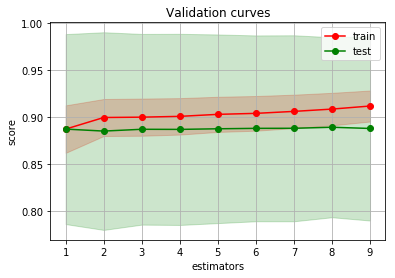

In [95]:
from sklearn.tree import DecisionTreeClassifier

rngs = range(1,10,1)
estimators = [DecisionTreeClassifier(max_depth=i) for i in rngs]
plot_cv_estimators(estimators, rngs, X,y)

The validation curve for the Decission Tree Classifier depicted above shows the behavior of the max_depth, as I increase this value the score is better. I will select the best estimator based on that parameter as follow.

In [96]:
def select_model(estimators, Xsel, ysel, Xtest, ytest):
    from sklearn.model_selection import cross_val_score, KFold
    means=[]
    for estimator in estimators:
        sc = cross_val_score(estimator, Xsel, ysel, cv=KFold(5))
        means.append(np.mean(sc))

    best_estimator      = estimators[np.argmax(means)]
    best_crossval_score = max(means)
    best_estimator.fit(Xsel, ysel)
    best_score = best_estimator.score(Xtest, ytest)
    return best_estimator, best_crossval_score, best_score

In [97]:
from sklearn.model_selection import train_test_split
a = []
for i in range(10):
    estimators = [DecisionTreeClassifier(max_depth=i) for i in range(1,10,1)]

    Xs, Xt, ys, yt = train_test_split(X, y, test_size=0.5)

    best, sc1, sc2 = select_model(estimators, Xs, ys, Xt, yt)
    a.append([sc1, sc2, best.max_depth])

In [98]:
print("          cv    test    max_depth")
print("promedios %.3f %.3f   %.3f"%tuple(np.mean(np.array(a), axis=0)))

          cv    test    max_depth
promedios 0.900 0.899   3.500


With this model selection I can decide which configuration is better for this kind of estimator. In that case I will use a Decision Tree Classifier with a max_depth of 3.

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

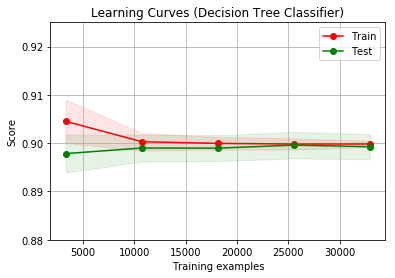

In [99]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
DT = DecisionTreeClassifier(max_depth=3)
title = "Learning Curves (Decision Tree Classifier)"
plot_learning_curve(DT, title, X, y, ylim=(0.88, 0.925), cv=cv, n_jobs=-1)

As I mentioned above with the configuration of **max_depth = 3**, the model with train and test datasets behaves pretty well with an accuracy of 90%. I will try to improve this accuracy using others estimators.

## Ensemble Methods
### Random Forest

I will try to use a Random Forest estimator to improve the accuracy of the Decision Tree. This estimator is very useful when we need a way to reduce the overfitting.

I will take a sample of the whole dataset to test of these kind of algorithm behave with less data.

In [100]:
Xr = X[:10000]
yr = y[:10000]
print(X.shape, y.shape)
print(Xr.shape, yr.shape)

(41188, 62) (41188,)
(10000, 62) (10000,)


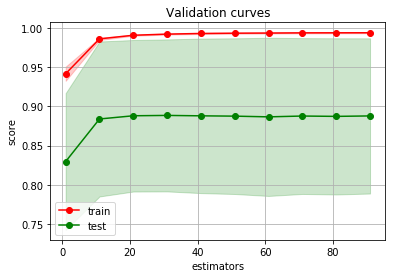

In [101]:
from sklearn.ensemble import RandomForestClassifier
rngs = range(1,100,10)
estimators = [RandomForestClassifier(n_estimators=i) for i in rngs]
plot_cv_estimators(estimators, rngs, X, y)

After different runnings with different configurations in the number of estimators, we can appreciate there is not any noticeable improving, so I will use 20 estimators for the random forest to reduce the amount of time taken by the algorithm.

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

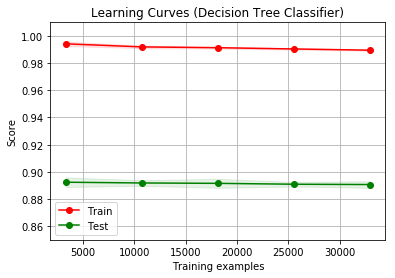

In [102]:
RF = RandomForestClassifier(n_estimators=20)
plot_learning_curve(RF, title, X, y, ylim=(0.85, 1.01), cv=cv, n_jobs=-1)

We can appreciate that there is no any sort of improving compared with the Decision Tree estimator by itself. This could be because of the complexity of the problem is very linear and these models become very complex.

Now, I will reduce the number of registers and test the random forest.

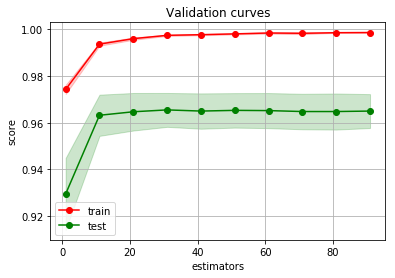

In [103]:
from sklearn.ensemble import RandomForestClassifier
rngs = range(1,100,10)
estimators = [RandomForestClassifier(n_estimators=i) for i in rngs]
plot_cv_estimators(estimators, rngs, Xr, yr)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

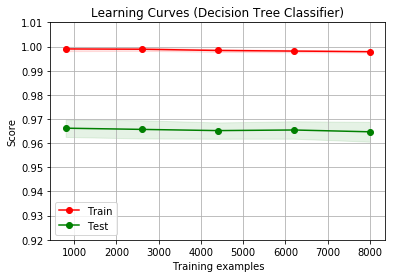

In [104]:
RF = RandomForestClassifier(n_estimators=50)
plot_learning_curve(RF, title, Xr, yr, ylim=(0.92, 1.01), cv=cv, n_jobs=-1)

With less number of registers the prediction gets better.

## Support Vector Machine
### Support Vector Classification

I will use a SVM to try to improve the score obtained with the last two estimators.

In [105]:
from sklearn.svm import SVC

First, I will try a SVM with different kernel configurations. The first one is the default kernel which is Radial and the second one will be the linear.

I need to take a sample of the whole dataset because it would take a lot of time proccesing all data with these algorithms, so I will use **Xr** and **yr** as samples took some steps above.

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

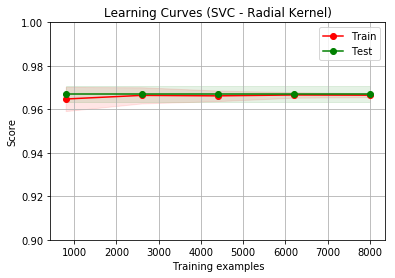

In [106]:
svc = SVC()
title = "Learning Curves (SVC - Radial Kernel)"
plot_learning_curve(svc, title, Xr, yr, ylim=(0.9, 1), cv=cv, n_jobs=-1)

Now, I will use a linear kernel and check the results 

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

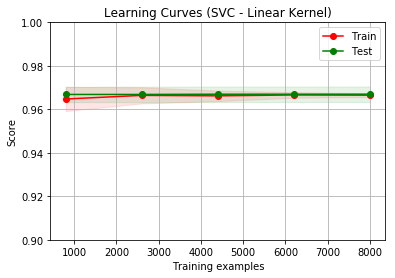

In [107]:
svc = SVC(kernel="linear")
title = "Learning Curves (SVC - Linear Kernel)"
plot_learning_curve(svc, title, Xr, yr, ylim=(0.9, 1), cv=cv, n_jobs=-1)

As you see both kernels have an excellent accuracy near to 97%.

Based on that I will try now to reduce the features without impact the accuracy.

## Reducing Features

The Decision Tree Classifier estimator has a variable called **feature\_importances\_** which is set when the model is trained, this variable shows an estimated importance value of each feature used during the training process.

In [108]:
DT.fit(X, y)
features = []
for i,col in enumerate(d.columns):
    if DT.feature_importances_[i] != 0:
        features.append(col)
        print("%20s %.3f"%(col, DT.feature_importances_[i]))

               pdays 0.128
       cons.conf.idx 0.068
           euribor3m 0.023
         nr.employed 0.731
    contact_cellular 0.016
           month_oct 0.026
     day_of_week_mon 0.007


In [109]:
df = d
df.drop(df.columns.difference(features), 1, inplace=True)
df.head(5)

,pdays,cons.conf.idx,euribor3m,nr.employed,contact_cellular,month_oct,day_of_week_mon
0,27,-36.4,4.857,5191.0,0,0,1
1,27,-36.4,4.857,5191.0,0,0,1
2,27,-36.4,4.857,5191.0,0,0,1
3,27,-36.4,4.857,5191.0,0,0,1
4,27,-36.4,4.857,5191.0,0,0,1


In [110]:
X2 = df.as_matrix()
X2.shape

(41188, 7)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

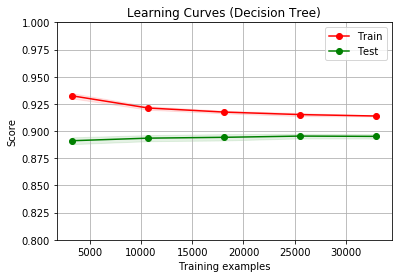

In [111]:
dt = DecisionTreeClassifier()
dt.fit(X2, y)
title = "Learning Curves (Decision Tree)"
plot_learning_curve(dt, title, X2, y, ylim=(0.8, 1), cv=cv, n_jobs=-1)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

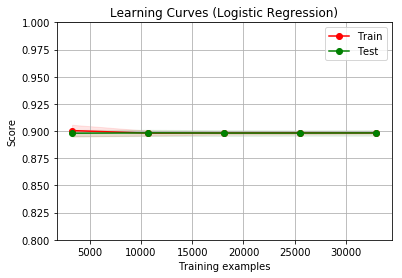

In [112]:
lr = LogisticRegression()
lr.fit(X2, y)
title = "Learning Curves (Logistic Regression)"
plot_learning_curve(lr, title, X2, y, ylim=(0.8, 1), cv=cv, n_jobs=-1)

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

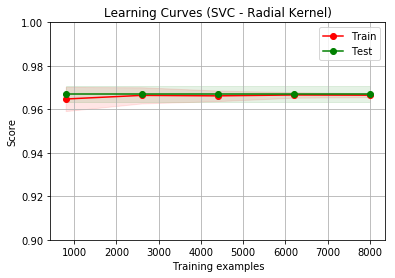

In [113]:
Xr = X2[:10000]
svc = SVC()
title = "Learning Curves (SVC - Radial Kernel)"
plot_learning_curve(svc, title, Xr, yr, ylim=(0.9, 1), cv=cv, n_jobs=-1)

I created the learning curves for the models trained with the features selected, as you can see, the accuracy is not being affected, therefore we could delete these feautures and reduce the complexity of the model without affect the classification.